In [114]:
from pandasql import sqldf
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from datetime import datetime, timedelta


In [115]:
#pip install pandasql

In [116]:
pysqldf = lambda q: sqldf(q, globals())

In [118]:
users = pd.read_csv('cleaned/users.csv', index_col = 0)
brands = pd.read_csv('cleaned/brands.csv', index_col = 0)
receipt = pd.read_csv('cleaned/receipts.csv', index_col = 0)
receiptItem = pd.read_pickle('cleaned/receiptitems.zip')
users['createdDate'] = pd.to_datetime(users['createdDate'])
date_col = ['createDate','dateScanned','finishedDate','purchaseDate','purchaseDate']
for col in date_col:
    receipt[f'{col}'] = pd.to_datetime(receipt[f'{col}'])

In [119]:
receiptItem.columns

Index(['receipt_id', 'barcode', 'description', 'finalPrice', 'itemPrice',
       'needsFetchReview', 'partnerItemId', 'preventTargetGapPoints',
       'quantityPurchased', 'userFlaggedNewItem', 'userFlaggedPrice',
       'userFlaggedQuantity', 'needsFetchReviewReason',
       'pointsNotAwardedReason', 'pointsPayerId', 'rewardsGroup',
       'rewardsProductPartnerId', 'originalMetaBriteBarcode',
       'originalMetaBriteDescription', 'brandCode', 'competitorRewardsGroup',
       'discountedItemPrice', 'originalReceiptItemText'],
      dtype='object')

## Q1: What are the top 5 brands by receipts scanned for most recent month?

In [120]:
q1 = """SELECT receipt.receipt_id, count(receiptItem.receipt_id) as receipt_count,

        receiptItem.brandCode, receipt.dateScanned as ds
        
        FROM receiptItem INNER JOIN receipt
        
        ON receiptItem.receipt_id = receipt.receipt_id WHERE brandCode <> "NO BRAND CODE"
        
        GROUP BY brandCode ORDER BY receipt_count DESC;"""


top_5_brands = pysqldf(q1)
top_5_brands = top_5_brands.sort_values(by="ds", ascending = False)
top_5_brands = top_5_brands.sort_values(by="receipt_count", ascending = False)

In [121]:
top_5_brands.head()

,receipt_id,receipt_count,brandCode,ds
0,6000b2be0a7214ad4c00004d,31624,BEN AND JERRYS,2021-01-14 00:00:00.000000
1,600206000a720f05f3000087,20577,HY-VEE,2021-01-15 00:00:00.000000
2,600206000a720f05f3000087,19737,KRAFT,2021-01-15 00:00:00.000000
3,5ff618e30a7214ada10005fa,14075,PEPSI,2021-01-06 00:00:00.000000
4,6000c8460a720f05f300006f,10799,KNORR,2021-01-14 00:00:00.000000


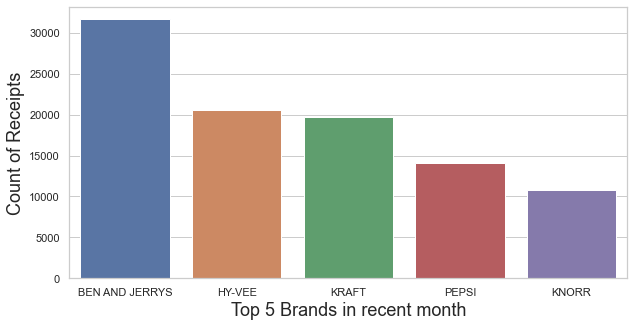

In [122]:
fig, scatter = plt.subplots(figsize = (10,5))
bar = sns.barplot(x="brandCode", y="receipt_count", data=top_5_brands.head(5) )
bar.set_xlabel('Top 5 Brands in recent month', fontsize = 18)
bar.set_ylabel ('Count of Receipts', fontsize = 18);

## Q2: How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

In [123]:
#TEST CODE
start_date = datetime(2021, 3, 1) 
end_date = datetime(2021, 2, 1)

# Convert dates to strings in the format 'YYYY-MM-DD'
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# SQL query
query = f"""
    with cte as (
        select 
            b.name, 
            dense_rank() over(partition by strftime('%Y-%m', date(dateScanned)) order by sum(ro.quantitypurchased) desc) as ranked
        from receiptItem ro 
            left join receipt r on cast(ro.receipt_id as text) = r.receipt_id
            left join brands b on b.barcode = ro.barcode 
        where b.topbrand = 1
            and date(r.dateScanned) between date('{start_date_str}') and date('{end_date_str}')
        group by b.name
    )
    select 
        name
    from cte
    where ranked <= 5;
"""

result = pysqldf(query)
print(result)



Empty DataFrame
Columns: [name]
Index: []


## Q3: When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [124]:
q3 = """SELECT receipt.rewardsReceiptStatus as reward_status, 
        
        avg(receipt.totalSpent) as avg_spend

        FROM receiptItem INNER JOIN receipt
        
        ON receiptItem.receipt_id = receipt.receipt_id GROUP BY reward_status;"""


accepted_rejected_spend = pysqldf(q3)
#accepted_rejected_spend = accepted_rejected_spend['reward_status'].replace('FINISHED', 'ACCEPTED')

In [125]:
accepted_rejected_spend

,reward_status,avg_spend
0,FINISHED,2416.713368
1,FLAGGED,3854.791179
2,REJECTED,31.432842


## Q4: When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [126]:
q4 = """select 
    case when
            (
            sum(case when rewardsReceiptStatus = 'Accepted' then purchaseditemcount end) -
            sum(case when rewardsReceiptStatus = 'Rejected' then purchaseditemcount end)
            ) > 0 
            then 'Total items purchased for Accepted is greater' 
            
            when
            (
            sum(case when rewardsReceiptStatus = 'Accepted' then purchaseditemcount end) -
            sum(case when rewardsReceiptStatus = 'Rejected' then purchaseditemcount end)
            ) = 0 
            then 'Both Accepted and Rejected status have same number items purchased' 
            
            ELSE 'Total items purchased for Rejected is greater' 
            end as result1
from receipt """

result1 = pysqldf(q4)
print(result1)

                                         result1
0  Total items purchased for Rejected is greater


## Q5: Which brand has the most spend among users who were created within the past 6 months?

In [127]:
from datetime import datetime
start_date = datetime(2021, 2, 2)
end_date = datetime(2020, 7, 2)

q5 = """
        SELECT receipt.receipt_id, users.user_id , users.createdDate, receipt.totalSpent
        FROM receipt JOIN users
        ON users.user_id = receipt.userId;
        """

users_spent = pysqldf(q5)

q51 = """
        SELECT users_spent.receipt_id, users_spent.createdDate, users_spent.totalSpent, 
        receiptItem.brandCode
        FROM users_spent JOIN receiptItem
        ON users_spent.receipt_id = receiptItem.receipt_id WHERE brandCode <> "NO BRAND CODE"
            
            """

users_spent1 = pysqldf(q51)
users_spent1['createdDate'] = pd.to_datetime(users_spent1['createdDate'])
users_spent1 = users_spent1.sort_values(by='createdDate',ascending=False).set_index('createdDate')

In [130]:
user_and_spents = users_spent1[(users_spent1.index <= start_date)
                 & (users_spent1.index >= end_date)]
user_and_spents = pd.DataFrame(user_and_spents.groupby(by='brandCode')['totalSpent'].sum().head(5))

In [131]:
user_and_spents

,totalSpent
brandCode,
7UP,3789390.30
ADVIL,1235173.11
AMERICAN BEAUTY,6374632.50
ARNOLD,144295.26
ARROWHEAD,3789390.30


## Q6: Which brand has the most transactions among users who were created within the past 6 months?

In [132]:

start_date = datetime(2021, 2, 2)
end_date = datetime(2020, 7, 2)

# Converted dates to strings format 'YYYY-MM-DD'
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

q6 = f"""
    SELECT
        b.brandCode,
        COUNT(*) AS transactionCnt
    FROM
        users u
    JOIN
        receipt r ON u.user_id = r.userId
    JOIN
        receiptItem ri ON r.receipt_id = ri.receipt_id
    JOIN
        brands b ON ri.brandCode = b.brandCode
    WHERE
        u.createdDate BETWEEN '{end_date_str}' AND '{start_date_str}'
    GROUP BY
        b.brandCode
    ORDER BY
        transactionCnt DESC
    LIMIT
        1;
"""

result = pysqldf(q6)
print(result)



  brandCode  transactionCnt
0     PEPSI           16698
